# presamples

## Introduction

This library allows you to use pre-generated values ("presamples") in LCA calculations. It builds on top of the [`Brightway LCA framework`](https://brightwaylca.org/).

Pre-generated arrays can be used in improve LCA calculations in many ways:

  * Seeded pre-sampled Monte Carlo values are reproducible
  * Pre-generated static or stochastic values can be generated by complex, non-linear models, capturing system dynamics more accurately
  * Pre-sampled Monte Carlo values can capture correlations between parameters, such as between characterization factors, or between input and outputs (e.g. fuel use and CO2 emissions)
  * Direct use of population data avoids losses from fitting data to distributions  
  * Scenario analysis or data refinement as layers applied to a common underlying model. 

Pre-generated arrays have two dimensions. Each row refers to a different quantified object used in the calculation of LCA results, such as exchange amounts, characterization factor values or named parameters values. Each column refers to a certain realization of the model. For example, this could refer to matrix values for a given Monte Carlo iteration or a given set of parameter values used in the modeling of a specific activity. 

There are two types of presamples - numbers that can be directly inserted into matrices used in LCA calculations, and named parameter values which can be used in either sensitivity analysis or to generate additional outputs. We call the first type "matrix presamples", and the second type "parameter presamples".

`presamples` also introduces the idea of *campaigns*, which organize presamples and allow for the systematic exploration of choices.


## Set-up

### Generic imports

In [1]:
import os
import numpy as np
import pandas as pd
import pyprind
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Brighway imports and setup

In [2]:
from brightway2 import *

In [3]:
projects.set_current('bw_presamples_use_cases')

In [4]:
bw2setup()

Biosphere database already present!!! No setup is needed


In [5]:
if 'ecoinvent 2.2' not in databases:
    ei22 = SingleOutputEcospold1Importer(
        r"Z:\CENTRE DOC\Logiciels et BD\ecoinvent\ecospolds\2.2\all",
        "ecoinvent 2.2"
    )
    ei22.apply_strategies()
    ei22.write_database()
else:
    print('ecoinvent 2.2 already imported')
db = Database('ecoinvent 2.2')

ecoinvent 2.2 already imported


### Presamples import

In [6]:
import presamples as ps

### Internal functions (for Notebook)  
Set of internal functions used in the Notebook to produce interesting calculations and displays, but not part of the `brightway_presamples` package.

In [7]:
def exc_to_df(exchanges, attributes, exc_name_lambda=None):
    """ Returns a DataFrame with specified attributes for list of exchanges.
    """
    if exc_name_lambda is None:
        exc_name_lambda = lambda x: x['name']
    rows = [exc_name_lambda(exc) for exc in exchanges]
    df = pd.DataFrame(index=rows, columns=attributes)
    for exc in exchanges:
        for att in attributes:
            df.loc[exc_name_lambda(exc), att] = exc[att]
    return df

In [8]:
def sampled_array_values_to_df(array, exc_names, col_names=[], include_sum=False):
    ''' Small function to format sampled values'''
    if not col_names:
        col_names = np.arange(array.shape[1])
    df = pd.DataFrame(index=exc_names,
                      columns = col_names,
                      data=array
                     )
    if include_sum:
        ser = pd.Series(df.sum(), name='Sum')
        df = df.append(ser)
    return df

In [9]:
def AB_sampled_values_to_df_MC(MC, exchanges, iterations=10, 
                         include_sum=False, exc_name_lambda=None):
    ''' Small function to format sampled values'''
    arr = np.zeros([len(exchanges), iterations])
    for it in range(iterations):
        next(MC)
        for row, exc in enumerate(exchanges):
            if exc['input'][0]=='biosphere3':
                arr[row, it] = MC.biosphere_matrix[
                    MC.biosphere_dict[exc.input],
                    MC.activity_dict[exc.output]
                ]
            else:
                arr[row, it] = MC.technosphere_matrix[
                    MC.product_dict[exc.input],
                    MC.activity_dict[exc.output]
                ]
                
    if exc_name_lambda is None:
        exc_name_lambda = lambda x: x['name']
    exc_names = [exc_name_lambda(exc) for exc in exchanges]
    df = sampled_array_values_to_df(arr, exc_names, col_names=[], include_sum=include_sum)
    return df

In [10]:
def A_sampled_values_to_df_lca(LCA_dict, exchanges,
                               include_sum=False, 
                               exc_name_lambda=None):
    ''' Small function to format sampled values'''
    col_names = [k for k in LCA_dict.keys()]
    if exc_name_lambda is None:
        exc_name_lambda = lambda x: x['name']
    exc_names = [exc_name_lambda(exc) for exc in exchanges]
    arr = np.empty(shape=[len(exc_names), len(col_names)])
    for col, lca in enumerate(col_names):
        for row, exc in enumerate(exchanges):
            arr[row, col] = LCA_dict[lca].technosphere_matrix[
                LCA_dict[lca].product_dict[exc.input],
                LCA_dict[lca].activity_dict[exc.output]
            ]
    df = sampled_array_values_to_df(arr, exc_names,
                                    col_names, include_sum)
    return df

### Constants

In [11]:
iterations = 2000

## Typical workflow

The typical workflow is as follows:  
- Import `presamples` package. For brevity, `import presamples as ps`
- Generate an [`ndarray`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html) of data to be reused in future calculations. `presamples` does not care *how* this data was generated. What is important, however, is that it is follows the following structure: rows refer to different types of quantified objects (typically matrix elements or parameter values), and columns refer to individual realizations of these  quantified objects (e.g. values all relating to a specific scenario or a given Monte Carlo iteration).  
- Generate and format information about what the rows of the array of data refers to. For matrix elements, what is required is `indices` and a `matrix label`. For named parameters, all that is neeeded is a list of names. In both cases, the length of indices and names needs to be the same as the number of rows in the samples array.  
- Create a `presamples_package`, which is basically a set of files on your computer that contains the samples arrays and information about these arrays. This is usually done using `ps.create_presamples_package(*args)` 
- The `presamples_packages` are then typically used in one of two ways:  
  - They can be loaded using `ps.PackagesDataLoader(dirpaths)`, where `dirpaths` is a list of filepaths to presamples package folders. This creates, among other things, `IrregularPresamplesArrays` (or. `ipa` for short), which return columns of values from the samples arrays, and `Indexers` that determine what columns of the `ipa` to return. The `ps.PackagesDataLoader` also knows how to pass the data back to matrix builders in Brightway.  
  - They can be passed directly to brightway `LCA` or `MonteCarloLCA` objects, which will generate and interract with  `ps.PackagesDataLoader` objects. 

## `presamples` for elements of LCA matrices

`presamples` can be used to directly insert values from arrays of numbers into the matrices used in LCA calculations, such as the technosphere matrix $\mathbf{A}$, the biosphere matrix $\mathbf{B}$, the characterization factor matrix $\mathbf{C}$ or any any other matrix, including matrices only used in LCA extensions such as regionalization. 

### How-to

#### Defining the input `matrix_data`

Precalculated samples for use in LCA matrices need to be organized in a list of `(samples, indices, matrix label)`.

* `samples` are a two-dimensional Numpy array, where each row contains values for a specific matrix element that will be replaced and each column contains values for a given realization of the LCA model.
* `indices` is an iterable with row and (usually) column indices. The *ith* element of `indices` refers to the *ith* row of the `samples`. The exact format of indices depends on the matrix to be constructed. These indices tell us where exactly to insert the samples into a specific matrix.
*  `matrix label` is a string giving the name of the matrix to be modified in the LCA class. This string is normally, but not necessarily, one of `('technosphere', 'biosphere', 'cf')`.

`presamples` contains helper functions to make this easy for common matrix presamples, such as those used in the technosphere, biosphere, and characterization matrices.

##### Samples arrays

The samples array is a numpy array populated with numbers. It has as many rows as there are elements that should be replaced in the matrices and as many columns as there are possible values that these elements can take. Samples arrays can have only one column.  
The samples array can be generated in any way. Some helper `presamples.models`, such as `FixedSum` and `KroneckerDelta`, exist to generate common samples arrays.

##### Indices for the technosphere matrix $\mathbf{A}$ and  biosphere matrix $\mathbf{B}$

The elements of $\mathbf{A}$ and $\mathbf{B}$ to be replaced are usually initially identified by indices of the format `[(input id, output id, type)]`. The ``type`` is an exchange type, i.e. one of "production", "technosphere", "biosphere", or "substitution".

If the presamples are for the **technosphere** matrix, then ``indices`` should have the form ``[(input id, output id, type)]``. ``input id`` and ``output id`` are activity identifiers like ``("my database", "my code")``. The ``type`` is an exchange type, i.e. one of "production", "technosphere", "biosphere", or "substitution".

If the presamples are for the **biosphere** matrix, then ``indices`` should have the form ``[(flow id, activity id)]``. Both these ``id`` values should should be activity identifiers like ``("my database", "my code")``.

Inventory presamples can include values for both the technosphere and biosphere matrices; you can use the ``split_inventory_presamples`` to split them up. This adds the `matrix label` automatically.

##### Indices for the characterization matrix $\mathbf{C}$

If the presamples are for the **characterization** matrix, then ``indices`` should have the form ``[flow id]``. The ``flow id`` should should be an activity identifier like ``("my flow database", "my code")``.

##### Custom matrices
Presamples can also be for other **custom matrices**. These can be accommodated with custom formatter function, or by specifying the metadata needed to process indices manually. See the documentations for more information.

#### Creating presamples packages 

Presamples are stored in `presample directories`, and saved using the function ``ps.create_presamples_package``.  

``ps.create_presamples_package(matrix_data)`` creates and populates a new presamples directory that stores:

  - The samples, as a numpy array, where rows are exchanges and columns are arrays;
  - The indices, as a numpy Numpy record array identifying what exchange the samples refer to; and
  - Information on the presample package, stored as a json Data Package

These three items are saved in a common directory. By default, the directory is in the projects directory (type `brightway.projects.dir` to see where this directory is for your current Brightway project). 

The following arguments are optional:
  * ``name``: A human-readable name for these samples.
  * ``id_``: Unique id for this collection of presamples. Optional, generated automatically if not set.
  * ``overwrite``: If True, replace an existing presamples package with the same ``_id`` if it exists. Default ``False``
  * ``dirpath``: An optional directory path where presamples can be created. Default is to create a subdirectory in the ``project`` folder.
  * ``seed``: Seed used by indexer to return array columns in random order. Can be an integer, "sequential" or None.

The function returns ``id_`` and the absolute path of the created directory.

#### Using presampled data

The Brightway calculation library `bw2calc` already knows how to load and use presamples. Using presamples in a calculation is therefore as simple as passing a list of presamples directories or a `Campaign` object to the LCA class you want to use. Internally, the `bw2calc` library will build the needed matrices for the calculation it is doing, and then replace elements in the matrices with values from the supplied presample arrays.

**Warning**: Due to the way presamples are implemented and the use of sparse matrices, presamples values must replace numbers *already present* in the matrix to be modified. Presamples should replace existing matrix values, not add new values to existing matrices.

### Use cases

#### Use case - modifying market shares

##### Example activity: Swiss enriched uranium market

Take the Swiss activity `uranium enriched 3.8%, for boiling water reactor`: 

In [12]:
U_market = [act for act in db 
            if 'uranium enriched 3.8%, for boiling water reactor' in act['name']
            and act['location']=='CH'
           ][0]
U_market

'uranium enriched 3.8%, for boiling water reactor' (kg SWU, CH, ['nuclear power', 'production'])

This activity has technosphere inputs:

In [13]:
U_inputs = [exc for exc in U_market.technosphere()]
len(U_inputs)

4

This activity is in fact a market, with inputs from different sources of enriched uranium:

In [14]:
exc_to_df(U_inputs, ['location', 'amount', 'unit'])

,location,amount,unit
"uranium, enriched 3.8%, at EURODIF enrichment plant",FR,0.52,kg SWU
"uranium, enriched 3.8%, at TENEX enrichment plant",RU,0.14,kg SWU
"uranium, enriched 3.8%, at URENCO enrichment plant",RER,0.2,kg SWU
"uranium, enriched 3.8%, at USEC enrichment plant",US,0.14,kg SWU


We can calculate the climate change life cycle score of 1 kg of uranium on this mix: 

In [15]:
U_lca_initial_mix =  LCA(
    {U_market:1},
    method=('IPCC 2013', 'climate change', 'GWP 100a')
)
U_lca_initial_mix.lci()
U_lca_initial_mix.lcia()
print('Initial mix: {:.2e} kg CO2e'.format(U_lca_initial_mix.score))

Initial mix: 6.04e+02 kg CO2e


We can inspect what values were used in the technosphere matrix $\mathbf{A}$. The values are as expected: they are the same as the exchange amounts, with a flipped sign.

In [16]:
U_lca_initial_mix.lci()
A_sampled_values_to_df_lca({'U - eurodif only':U_lca_initial_mix}, 
                           exchanges=U_inputs)

,U - eurodif only
"uranium, enriched 3.8%, at EURODIF enrichment plant",-0.52
"uranium, enriched 3.8%, at TENEX enrichment plant",-0.14
"uranium, enriched 3.8%, at URENCO enrichment plant",-0.20
"uranium, enriched 3.8%, at USEC enrichment plant",-0.14


##### Use case: Choosing a specific supplier in a mix

One may decide, for a given model run, that all uranium comes from EURODIF. One can therefore create a matrix_presample that reflects this.

**Creating the `matrix_presamples`**

Samples array:

In [17]:
U_samples_eurodif_only = np.array(
    [1 if 'EURODIF' in exc['name'] else 0 for exc in U_inputs]
)
U_samples_eurodif_only = U_samples_eurodif_only.reshape(1, -1).T
U_samples_eurodif_only

array([[1],
       [0],
       [0],
       [0]])

Indices

In [18]:
U_indices = [(exc['input'], exc['output'], 'technosphere')
                        for exc in U_inputs
                       ]
U_indices

[(('ecoinvent 2.2', '99f1f0029f474ace11ac242a973a4e87'),
  ('ecoinvent 2.2', 'bf1e7c6b273bc7aed4c9d0f949f1b918'),
  'technosphere'),
 (('ecoinvent 2.2', '9c35c990bca26d9bd534a3b8c2539743'),
  ('ecoinvent 2.2', 'bf1e7c6b273bc7aed4c9d0f949f1b918'),
  'technosphere'),
 (('ecoinvent 2.2', 'cf1e51c4684443b1dd607dc0feda2e81'),
  ('ecoinvent 2.2', 'bf1e7c6b273bc7aed4c9d0f949f1b918'),
  'technosphere'),
 (('ecoinvent 2.2', 'b95c51c1a187d7825d9e4ba7ad199662'),
  ('ecoinvent 2.2', 'bf1e7c6b273bc7aed4c9d0f949f1b918'),
  'technosphere')]

The `matrix_label` can be included directly:

In [19]:
U_eurodif_matrix_presamples_manual = [
    (
        U_samples_eurodif_only,
        U_indices,
        'technosphere'
    )
]

It can also be created using the `split_inventory` function:

In [20]:
U_eurodif_matrix_presamples_split = [
    x for x in ps.split_inventory_presamples(
        U_samples_eurodif_only,
        U_indices
    )
    if x[2]=='technosphere'
]

They are equivalent:

In [21]:
U_eurodif_matrix_presamples_manual[0][0]==U_eurodif_matrix_presamples_split[0][0]

array([[ True],
       [ True],
       [ True],
       [ True]], dtype=bool)

**Creating the `presamples_package`**

`presamples` has a convenient function to do just that: `ps.create_presamples_package`

In [22]:
U_eurodif_id, U_eurodif_fp = ps.create_presamples_package(
    matrix_data=U_eurodif_matrix_presamples_manual,
    name='U - eurodif only'
)

In [23]:
U_eurodif_id, U_eurodif_fp

('98591dc47b434424a50ae288a2f57d9f',
 WindowsPath('C:/Users/Pascal Lesage/AppData/Local/pylca/Brightway3/bw_presamples_use_cases.ef3069e720c96c81526b01fe27ca7cfc/presamples/98591dc47b434424a50ae288a2f57d9f'))

The presamples package was stored in the default directory, found in the project directory.

**Using the presamples in an LCA**`

In [24]:
U_lca_eurodif_only = LCA(
    {U_market:1},
    method=('IPCC 2013', 'climate change', 'GWP 100a'),
    presamples=[U_eurodif_fp])

We can check that the used data is what we expect it to be:

In [25]:
U_lca_eurodif_only.lci()
A_sampled_values_to_df_lca({'U - eurodif only':U_lca_eurodif_only}, 
                           exchanges=U_inputs)

,U - eurodif only
"uranium, enriched 3.8%, at EURODIF enrichment plant",-1.0
"uranium, enriched 3.8%, at TENEX enrichment plant",0.0
"uranium, enriched 3.8%, at URENCO enrichment plant",0.0
"uranium, enriched 3.8%, at USEC enrichment plant",0.0


The climate change score is calculated using these new values:

In [26]:
U_lca_eurodif_only.lcia()
print('EURODIF only: {:.2e} kg CO2e'.format(U_lca_eurodif_only.score))

EURODIF only: 2.58e+02 kg CO2e


##### Use case: comparing scenarios

Say that one wants to compare the climate change score when the uranium supplier changes, assuming that all uranium will be supplied by only one supplier. To do so, we can generate a presamples package where each column represents a different scenario:

In [27]:
U_one_at_a_time_samples = np.eye(4)
U_one_at_a_time_samples

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

**Creating the `matrix_data`**

In [28]:
U_one_at_a_time_presamples_matrix = [
    (U_one_at_a_time_samples,
     U_indices,
     'technosphere'
    )
]

**Creating the `presamples_package`**

In [29]:
U_one_at_a_time_id, U_one_at_a_time_fp = ps.create_presamples_package(
    matrix_data=U_one_at_a_time_presamples_matrix,
    seed='sequential'
)

**Using in an LCA**

The `presample_package` filepath is simply passed when creating the `LCA` object:

In [30]:
U_lca_one_at_a_time = LCA(
    {U_market:1},
    method=('IPCC 2013', 'climate change', 'GWP 100a'),
    presamples=[U_one_at_a_time_fp],
)

we can check that the right values were sampled.

In [31]:
df = pd.DataFrame(index=[exc['name'] for exc in U_inputs], columns=[exc['name'] for exc in U_inputs])
df.index.name = "exchanges"
df.columns.name = "scenario"
for i, expected_exc in enumerate(U_inputs):
    if i==0:
        U_lca_one_at_a_time.lci()
    else:
        U_lca_one_at_a_time.presamples.update_matrices(U_lca_one_at_a_time)
        U_lca_one_at_a_time.redo_lci()
    for actual_exc in U_inputs:
        df.loc[expected_exc['name'], actual_exc['name']] = U_lca_one_at_a_time.technosphere_matrix[
                        U_lca_one_at_a_time.product_dict[actual_exc.input],
                        U_lca_one_at_a_time.activity_dict[actual_exc.output]
        ]
        

In [32]:
df

scenario,"uranium, enriched 3.8%, at EURODIF enrichment plant","uranium, enriched 3.8%, at TENEX enrichment plant","uranium, enriched 3.8%, at URENCO enrichment plant","uranium, enriched 3.8%, at USEC enrichment plant"
exchanges,,,,
"uranium, enriched 3.8%, at EURODIF enrichment plant",-1,0,0,0
"uranium, enriched 3.8%, at TENEX enrichment plant",0,-1,0,0
"uranium, enriched 3.8%, at URENCO enrichment plant",0,0,-1,0
"uranium, enriched 3.8%, at USEC enrichment plant",0,0,0,-1


##### Use case: Fixing the sum of market shares to 1

In the uranium market example, the sum of the inputs is 1: 

In [33]:
sum([exc['amount'] for exc in U_inputs])

1.0

The inputs are also uncertain:

In [34]:
loc_lambda = lambda x: x['location']
exc_to_df(U_inputs, ['uncertainty type', 'scale'])

,uncertainty type,scale
"uranium, enriched 3.8%, at EURODIF enrichment plant",2,0.0911608
"uranium, enriched 3.8%, at TENEX enrichment plant",2,0.346574
"uranium, enriched 3.8%, at URENCO enrichment plant",2,0.202733
"uranium, enriched 3.8%, at USEC enrichment plant",2,0.549306


In a regular Monte-Carlo simulation, each of these inputs is independently sampled.  
The sum of the inputs will therefore not equal the expected output, i.e. 1 kg.

In [35]:
# Instantiate the MonteCarloLCA object
U_MC_independent = MonteCarloLCA(
    {U_market:1},
    method=('IPCC 2013', 'climate change', 'GWP 100a')
)

In [36]:
AB_sampled_values_to_df_MC(U_MC_independent,
                          U_inputs,
                          include_sum=True,
                         )

,0,1,2,3,4,5,6,7,8,9
"uranium, enriched 3.8%, at EURODIF enrichment plant",-0.539342,-0.536558,-0.497623,-0.511241,-0.495635,-0.543382,-0.543403,-0.489408,-0.558227,-0.620739
"uranium, enriched 3.8%, at TENEX enrichment plant",-0.120382,-0.230796,-0.211981,-0.105182,-0.083103,-0.132841,-0.201797,-0.182044,-0.173270,-0.219886
"uranium, enriched 3.8%, at URENCO enrichment plant",-0.193296,-0.201575,-0.192465,-0.317511,-0.162308,-0.198826,-0.228923,-0.185495,-0.155697,-0.160835
"uranium, enriched 3.8%, at USEC enrichment plant",-0.147740,-0.146500,-0.200619,-0.083707,-0.193871,-0.032172,-0.153501,-0.093125,-0.084874,-0.274445
Sum,-1.000760,-1.115429,-1.102688,-1.017640,-0.934916,-0.907221,-1.127623,-0.950072,-0.972068,-1.275906


**Generating the `matrix_data`**

bw_presamples has a model, `FixedSum`, that generates matrix presamples for which the sum of inputs is equal to some amount for all Monte Carlo iterations. That amount is normally the sum of static values. This is naively ensured by simple rescaling.

In [37]:
from presamples.models import FixedSum

In [38]:
U_fixed_sum_10 = FixedSum(exchanges=U_inputs, iterations=10)

Note that the instantiation takes as argument `exchanges`.  These can be passed as either:  
  - an Exchange proxy, used in Brightway2  
  - A tuple of the form `(input key, output key)` or `(input key, output key, type)`, where `type` is e.g. technosphere or biosphere  
  - A dictionary describing the exchange (with minimally the input, output and type)  
  
In our cases, we passed the Exchange proxy directly

The `run` method will generate samples that sum to 1: 

In [39]:
U_fixed_sum_samples_10 = U_fixed_sum_10.run()

In [40]:
sampled_array_values_to_df(U_fixed_sum_samples_10,
                           [exc['name'] for exc in U_inputs],
                           include_sum=True
                          )

,0,1,2,3,4,5,6,7,8,9
"uranium, enriched 3.8%, at EURODIF enrichment plant",0.511626,0.526474,0.540155,0.551528,0.571557,0.543772,0.502438,0.563152,0.469870,0.566520
"uranium, enriched 3.8%, at TENEX enrichment plant",0.239756,0.133385,0.085346,0.095228,0.132040,0.093755,0.145722,0.086364,0.121777,0.118730
"uranium, enriched 3.8%, at URENCO enrichment plant",0.179236,0.153630,0.176245,0.264773,0.219860,0.143846,0.238469,0.229835,0.169241,0.220685
"uranium, enriched 3.8%, at USEC enrichment plant",0.069383,0.186511,0.198254,0.088471,0.076543,0.218627,0.113371,0.120649,0.239111,0.094064
Sum,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Once run, the fixed_sum model has properly formatted matrix data:

In [41]:
U_fixed_sum_10.matrix_data

[(array([[ 0.51162569,  0.5264742 ,  0.54015495,  0.55152811,  0.57155711,
           0.54377233,  0.50243794,  0.56315239,  0.46987003,  0.5665202 ],
         [ 0.23975618,  0.13338493,  0.08534604,  0.09522802,  0.13204001,
           0.09375498,  0.14572175,  0.08636397,  0.12177733,  0.11873032],
         [ 0.1792356 ,  0.1536299 ,  0.17624485,  0.26477325,  0.21986001,
           0.14384596,  0.23846923,  0.22983461,  0.1692412 ,  0.22068529],
         [ 0.06938253,  0.18651097,  0.19825416,  0.08847062,  0.07654287,
           0.21862673,  0.11337108,  0.12064903,  0.23911144,  0.09406418]]),
  [(('ecoinvent 2.2', '99f1f0029f474ace11ac242a973a4e87'),
    ('ecoinvent 2.2', 'bf1e7c6b273bc7aed4c9d0f949f1b918'),
    'technosphere'),
   (('ecoinvent 2.2', '9c35c990bca26d9bd534a3b8c2539743'),
    ('ecoinvent 2.2', 'bf1e7c6b273bc7aed4c9d0f949f1b918'),
    'technosphere'),
   (('ecoinvent 2.2', 'cf1e51c4684443b1dd607dc0feda2e81'),
    ('ecoinvent 2.2', 'bf1e7c6b273bc7aed4c9d0f949f1b918')

Let's create a `fixed_sum` object with a more reasonable number of iterations, say 1000:

In [42]:
U_fixed_sum_1000 = FixedSum(exchanges=U_inputs, iterations=1000)
U_fixed_sum_1000.run()

array([[ 0.53482101,  0.38937267,  0.5007791 , ...,  0.45086984,
         0.55340475,  0.52494931],
       [ 0.19652726,  0.08641107,  0.08815761, ...,  0.24327175,
         0.09590053,  0.17455355],
       [ 0.20473102,  0.21045888,  0.19415843, ...,  0.13137351,
         0.17732497,  0.22266128],
       [ 0.06392071,  0.31375738,  0.21690486, ...,  0.1744849 ,
         0.17336975,  0.07783587]])

**Creating the `presamples_package`**

The `create_presamples_package` function can be used, passing as argument the `matrix_data`. To make this even easier, the presamples package can be created using a convenience method: 

In [43]:
U_fixed_sum_id, U_fixed_sum_fp = U_fixed_sum_1000.create_presample_package()

**Using the `presamples_package`**

As with the static LCA, the `presamples_package` is simply passed as a list of presamples file paths when instantiating the Monte Carlo object:

In [44]:
U_MC_fixed_sum = MonteCarloLCA(
    {U_market:1}, 
    method=('IPCC 2013', 'climate change', 'GWP 100a'),
    presamples=[U_fixed_sum_fp]
)

Again, we can check that the sampled market input amounts indeed sum to 1 (actually, negative 1) for each iteration.

In [45]:
AB_sampled_values_to_df_MC(U_MC_fixed_sum,
                          U_inputs,
                          include_sum=True,
                         )

,0,1,2,3,4,5,6,7,8,9
"uranium, enriched 3.8%, at EURODIF enrichment plant",-0.568457,-0.580310,-0.545635,-0.574391,-0.436840,-0.505960,-0.547725,-0.442260,-0.449986,-0.486627
"uranium, enriched 3.8%, at TENEX enrichment plant",-0.110613,-0.177312,-0.122160,-0.110681,-0.221817,-0.107749,-0.182769,-0.086065,-0.108268,-0.085114
"uranium, enriched 3.8%, at URENCO enrichment plant",-0.204738,-0.173619,-0.189823,-0.228507,-0.186700,-0.290272,-0.168099,-0.153562,-0.204951,-0.321634
"uranium, enriched 3.8%, at USEC enrichment plant",-0.116192,-0.068759,-0.142382,-0.086422,-0.154643,-0.096019,-0.101408,-0.318114,-0.236795,-0.106625
Sum,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000


##### Use case: Choosing a (possibly weighted) random supplier

Suppose that a specific power plant will only buy their uranium from one of the sources, but it is not known which.  
In this case, what we need to model is no longer a mix of fuels, but rather a specific fuel for each iteration.  

**Generating the `presamples_data`**

bw_presamples has a model, `KroneckerDelta`, that generates matrix presamples for which only one of the inputs has a non-zero amount. This amount can be the initial amount or some other, specified amount. In our case, we want the non-zero amount to be 1.

In [46]:
from presamples.models import KroneckerDelta

In [47]:
U_one_random_10 = KroneckerDelta(exchanges=U_inputs, iterations=10)

In [48]:
U_one_random_10_samples = U_one_random_10.run()

This returns an array where one input is set to one and others are set to 0. Because we did not specify `equal_choice`, the initial amounts are used as weights: the larger the initial amount, the higher the probability that a given input is chosen.

In [49]:
sampled_array_values_to_df(U_one_random_10_samples,
                           [exc['name'] for exc in U_inputs],
                           include_sum=True
                          )

,0,1,2,3,4,5,6,7,8,9
"uranium, enriched 3.8%, at EURODIF enrichment plant",1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
"uranium, enriched 3.8%, at TENEX enrichment plant",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"uranium, enriched 3.8%, at URENCO enrichment plant",0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"uranium, enriched 3.8%, at USEC enrichment plant",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Sum,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


Once run, the kronecker_delta model has properly formatted matrix data:

In [50]:
U_one_random_10.matrix_data

[(array([[ 1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]]),
  [(('ecoinvent 2.2', '99f1f0029f474ace11ac242a973a4e87'),
    ('ecoinvent 2.2', 'bf1e7c6b273bc7aed4c9d0f949f1b918'),
    'technosphere'),
   (('ecoinvent 2.2', '9c35c990bca26d9bd534a3b8c2539743'),
    ('ecoinvent 2.2', 'bf1e7c6b273bc7aed4c9d0f949f1b918'),
    'technosphere'),
   (('ecoinvent 2.2', 'cf1e51c4684443b1dd607dc0feda2e81'),
    ('ecoinvent 2.2', 'bf1e7c6b273bc7aed4c9d0f949f1b918'),
    'technosphere'),
   (('ecoinvent 2.2', 'b95c51c1a187d7825d9e4ba7ad199662'),
    ('ecoinvent 2.2', 'bf1e7c6b273bc7aed4c9d0f949f1b918'),
    'technosphere')],
  'technosphere')]

Let's create a `matrix_presamples` with 1000 iterations:

In [51]:
U_one_random_1000 = KroneckerDelta(exchanges=U_inputs, iterations=1000)
U_one_random_1000.run()

array([[ 1.,  1.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  1., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

**Creating the `presamples_package`**

Again, a method makes this easy:

In [52]:
U_one_random_id, U_one_random_fp = U_one_random_1000.create_presample_package()

**Using the `presamples_package`**

The `presamples_package` filepath is simply passed when instantiating the MonteCarloLCA object:

In [53]:
U_MC_one_random = MonteCarloLCA(
    {U_market:1}, 
    method=('IPCC 2013', 'climate change', 'GWP 100a'),
    presamples=[U_one_random_fp]
)

We can check the sampled values actually used in LCA:

In [54]:
AB_sampled_values_to_df_MC(U_MC_one_random,
                          U_inputs,
                          include_sum=True,
                         )

,0,1,2,3,4,5,6,7,8,9
"uranium, enriched 3.8%, at EURODIF enrichment plant",-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,0.0,-1.0
"uranium, enriched 3.8%, at TENEX enrichment plant",0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
"uranium, enriched 3.8%, at URENCO enrichment plant",0.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0
"uranium, enriched 3.8%, at USEC enrichment plant",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sum,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


##### Use case wrap-up: comparing results

We can compare the uncertainty of results for the different cases we were interested in before:  
  - Market as in database  
  - Initial improvement: ensure inputs sum to 1  
  - Choose a random input  
  - Choose a specific input  
  
We have already created `MonteCarloLCA` objects for the first three of these. Let's create one for the fourth case (specific input, initially modelled statically above):

In [55]:
U_MC_eurodif_only = MonteCarloLCA(
    {U_market:1}, 
    method=('IPCC 2013', 'climate change', 'GWP 100a'),
    presamples=[U_eurodif_fp]
)

We can now generate samples for all four cases, and compare results graphically:

In [56]:
iterations = iterations
U_MC_samples_independent = np.zeros(iterations)
U_MC_samples_fixed_sum = np.zeros(iterations)
U_MC_samples_one_random = np.zeros(iterations)
U_MC_samples_eurodif_only = np.zeros(iterations)

for i in pyprind.prog_bar(range(iterations)):
    next(U_MC_independent)
    next(U_MC_fixed_sum)
    next(U_MC_one_random)
    next(U_MC_eurodif_only)
    
    U_MC_samples_independent[i] = U_MC_independent.score
    U_MC_samples_fixed_sum[i] = U_MC_fixed_sum.score
    U_MC_samples_one_random[i] = U_MC_one_random.score
    U_MC_samples_eurodif_only[i] = U_MC_eurodif_only.score

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:06:33


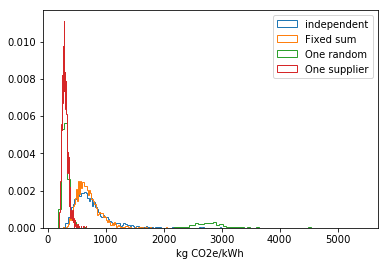

In [57]:
plt.hist(U_MC_samples_independent, bins=100, histtype='step', normed=True, label='independent')
plt.hist(U_MC_samples_fixed_sum, bins=100, histtype='step', normed=True, label='Fixed sum')
plt.hist(U_MC_samples_one_random, bins=100, histtype='step', normed=True, label='One random')
plt.hist(U_MC_samples_eurodif_only, bins=100, histtype='step', normed=True, label='One supplier')
plt.legend()
plt.gca().set_xlabel('kg CO2e/kWh');

##### Note on using multiple presamples that refer to the same matrix elements

When multiple `presamples` with matrix elements are used in an `LCA` or `MonteCarloLCA` object, only the last presamples package that refers to this element will be used: others are supplanted as new data becomes available.  
This is expected and useful behaviour. It allows one to successively refine a given model. Take for example a case where an LCA on the uranium market would first model independently (no presamples), then use a first presamples package to fix the sum, then decide it would be better to model the input as one random supplier, only to finally, after more data collection, replace values to effectively choose the correct supplier. The MonteCarloLCA object could be built as follows:  

In [58]:
U_MC_successive_refinement = MonteCarloLCA(
    {U_market:1},
    method=('IPCC 2013', 'climate change', 'GWP 100a'),
    presamples=[U_fixed_sum_fp, U_one_random_fp, U_eurodif_fp]
)

In [59]:
AB_sampled_values_to_df_MC(U_MC_successive_refinement,
                          U_inputs,
                          include_sum=True,
                         )

,0,1,2,3,4,5,6,7,8,9
"uranium, enriched 3.8%, at EURODIF enrichment plant",-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
"uranium, enriched 3.8%, at TENEX enrichment plant",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"uranium, enriched 3.8%, at URENCO enrichment plant",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"uranium, enriched 3.8%, at USEC enrichment plant",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sum,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


#### Use case: balancing land transformation flows in the biosphere matrix $\mathbf{B}$

Land transformation impacts are characterized using `Transformation from x` and `Transformation to y` elementary flows. These should balance, and they do for static LCA. Take a the disposal of non-sulfidic overburden, off-site from a mine as an examples:

In [60]:
mine = [act for act in db if act['name']=='disposal, non-sulfidic overburden, off-site'][0]
mine

'disposal, non-sulfidic overburden, off-site' (kilogram, GLO, ['waste management', 'residual material landfill'])

In [61]:
mine_land_trans = [exc for exc in mine.biosphere() 
                   if 'Transformation' in exc['name']]
for exc in mine_land_trans:
    print("{}: {} {}".format(exc['name'], exc['amount'], exc['unit']))

Transformation, from unspecified: 5.1e-05 square meter
Transformation, to dump site: 5.1e-05 square meter


In a `MonteCarloLCA`, however, the values are independently sampled for both flows:

In [62]:
mine_MC_independent = MonteCarloLCA(
    {mine:1},
    method=('ILCD 1.0.8 2016 midpoint', 'resources', 'land use')
)

In [63]:
AB_sampled_values_to_df_MC(mine_MC_independent,
                           mine_land_trans,
                           iterations=5, 
                           include_sum=False)

,0,1,2,3,4
"Transformation, from unspecified",0.000036,0.000048,0.000066,0.000064,0.000124
"Transformation, to dump site",0.000043,0.000059,0.000063,0.000051,0.000070


The transfomation amounts can be set equal to one another. First, "transformation from" is sampled, and then "transformation to" is simply a copy of "transformation from":

In [64]:
mine_land_transf_from = mine_land_trans[0].random_sample(1000)
mine_land_transf_to = mine_land_transf_from

The `samples_array` would then simply be these two arrays concatenated:

In [65]:
mine_transformation_samples = np.stack([mine_land_transf_from, mine_land_transf_to], axis=0)
mine_transformation_samples

array([[  2.70407132e-05,   6.87903229e-05,   5.58079759e-05, ...,
          8.23768981e-05,   3.67587546e-05,   4.59743783e-05],
       [  2.70407132e-05,   6.87903229e-05,   5.58079759e-05, ...,
          8.23768981e-05,   3.67587546e-05,   4.59743783e-05]])

The indices for biosphere flows are of the form `[(flow id, activity id)]`:

In [66]:
mine_transformation_indices = [(exc.input.key, exc.output.key, 'biosphere') for exc in mine_land_trans]
mine_transformation_indices

[(('biosphere3', '29630a65-f38c-48a5-9744-c0121f586640'),
  ('ecoinvent 2.2', '7733e598102e7913e3cf607f4ef351c0'),
  'biosphere'),
 (('biosphere3', '90a5a447-af6f-421a-8201-011f07ad1150'),
  ('ecoinvent 2.2', '7733e598102e7913e3cf607f4ef351c0'),
  'biosphere')]

The `matrix_data` is therefore simply:

In [67]:
mine_matrix_data = [
    (
        mine_transformation_samples,
        mine_transformation_indices,
        'biosphere'
    )
]

This can be passed directly to `ps.create_presamples_package`:

In [68]:
mine_corr_id, mine_corr_fp = ps.create_presamples_package(mine_matrix_data)

The resulting presample pacakge can be used in a `MonteCarloLCA` object:

In [69]:
mine_MC_correlated = MonteCarloLCA(
    {mine:1},
    method=('ILCD 1.0.8 2016 midpoint', 'resources', 'land use'),
    presamples=[mine_corr_fp]
)

In [70]:
AB_sampled_values_to_df_MC(mine_MC_correlated,
                           mine_land_trans,
                           iterations=5, 
                           include_sum=False)

,0,1,2,3,4
"Transformation, from unspecified",0.000076,0.000061,0.000065,0.000033,0.000044
"Transformation, to dump site",0.000076,0.000061,0.000065,0.000033,0.000044


This has an effect on the calculated uncertainty:

In [71]:
iterations = iterations
mine_samples_independent = np.zeros(iterations)
mine_samples_correlated = np.zeros(iterations)

for i in pyprind.prog_bar(range(iterations)):
    next(mine_MC_independent)
    next(mine_MC_correlated)
    
    mine_samples_independent[i] = mine_MC_independent.score
    mine_samples_correlated[i] = mine_MC_correlated.score

0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:02:52


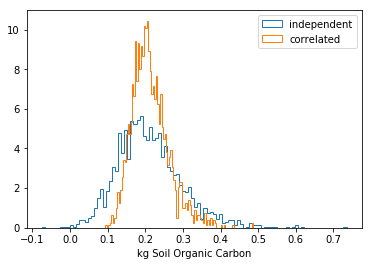

In [72]:
plt.hist(mine_samples_independent, bins=100, histtype='step', normed=True, label='independent')
plt.hist(mine_samples_correlated, bins=100, histtype='step', normed=True, label='correlated')
plt.legend()
plt.gca().set_xlabel(Method(('ILCD 1.0.8 2016 midpoint', 'resources', 'land use')).metadata['unit']);

### Use case: correlating fuel and emissions

In combustion activities, CO2 emissions are of course dependent on fossil fuel inputs. However, this dependence is not always accounted for in LCI data. Notably, in ecoinvent, both fuel inputs and CO2 emissions are uncertain, but there is no data that would allow them to be sampled dependently in an uncertainty analysis.

Take a unit process describing a coal power plant in Germany:

In [73]:
combustion_act = [act for act in db 
              if 'hard coal, burned' in act['name']
              and act['location']=='DE'
             ][0]
combustion_act

'hard coal, burned in power plant' (megajoule, DE, ['hard coal', 'power plants'])

The fuel input is: 

In [74]:
combustion_coal_input = [exc for exc in combustion_act.technosphere() if 'hard coal supply mix' in exc['name']][0]
combustion_coal_input

Exchange: 0.0417 kilogram 'hard coal supply mix' (kilogram, DE, ['hard coal', 'production']) to 'hard coal, burned in power plant' (megajoule, DE, ['hard coal', 'power plants'])>

The CO2 emissions are:

In [75]:
combustion_CO2_emissions = [exc for exc in combustion_act.biosphere() if 'Carbon dioxide' in exc['name']][0]
combustion_CO2_emissions

Exchange: 0.0922 kilogram 'Carbon dioxide, fossil' (kilogram, None, ('air', 'non-urban air or from high stacks')) to 'hard coal, burned in power plant' (megajoule, DE, ['hard coal', 'power plants'])>

And the ratio between the two is:

In [76]:
CO2_per_kg_coal = combustion_CO2_emissions['amount']/combustion_coal_input['amount']
CO2_per_kg_coal

2.211031175059952

Note that both exchanges are uncertain:

In [77]:
exc_to_df([combustion_coal_input, combustion_CO2_emissions], ['uncertainty type', 'scale'])

,uncertainty type,scale
hard coal supply mix,2,0.069881
"Carbon dioxide, fossil",2,0.05218


Because both exchanges are independently sampled, the ratio of CO2 emissions to fuel input is not constant across Monte Carlo iteration:

In [78]:
combustion_MC_independent = MonteCarloLCA(
    {combustion_act:1},
    method=('IPCC 2013', 'climate change', 'GWP 100a')
    )

In [79]:
df_independent = AB_sampled_values_to_df_MC(
    combustion_MC_independent,
    [combustion_coal_input, combustion_CO2_emissions],
    ).T
df_independent['ratio'] = df_independent['Carbon dioxide, fossil']/df_independent['hard coal supply mix']
df_independent.T

,0,1,2,3,4,5,6,7,8,9
hard coal supply mix,-0.038020,-0.047073,-0.043349,-0.042886,-0.042406,-0.041207,-0.041505,-0.043948,-0.044566,-0.038501
"Carbon dioxide, fossil",0.089013,0.084130,0.089088,0.100115,0.088236,0.094242,0.100427,0.092120,0.083468,0.092824
ratio,-2.341241,-1.787231,-2.055121,-2.334464,-2.080758,-2.287031,-2.419624,-2.096121,-1.872921,-2.410921


We can replace sampled values with precalculated fuel input and CO2 emission values that account for the dependence between the two. Let's first sample some coal inputs, and then calculate CO2 emissions using the CO2/fuel ratio determined using the static activity data.

In [80]:
combustion_coal_sample = combustion_coal_input.random_sample(1000).reshape(1, -1)
combustion_CO2_sample = combustion_coal_sample * CO2_per_kg_coal

Of course, by design, the ratio between the two is constant:

In [81]:
(combustion_CO2_sample/combustion_coal_sample)[0][0:10]

array([ 2.21103118,  2.21103118,  2.21103118,  2.21103118,  2.21103118,
        2.21103118,  2.21103118,  2.21103118,  2.21103118,  2.21103118])

These arrays can be used to create a presamples package. We first define two `matrix_data` tuples, one per exchange type (technosphere, biosphere):

In [82]:
combustion_corr_matrix_data_A = (
    combustion_coal_sample,
    [(combustion_coal_input['input'], combustion_coal_input['output'], 'technosphere')],
    'technosphere'
    )

combustion_corr_matrix_data_B = (
    combustion_CO2_sample,
    [(combustion_CO2_emissions['input'], combustion_CO2_emissions['output'], 'biosphere')],
    'biosphere'
    )

They can then both be passed to `ps.create_presamples_package`. In fact, any number of arrays and associated indices can be passed to `create_presamples_package`, as long as they are all valid and all have the same number of columns.

In [83]:
combustion_corr_id, combustion_corr_fp = ps.create_presamples_package(
    matrix_data=[
        combustion_corr_matrix_data_A,
        combustion_corr_matrix_data_B
    ]
)

Let's check that the presampled values are actually used in a Monte Carlo LCA: 

In [84]:
combustion_MC_correlated = MonteCarloLCA(
    {combustion_act:1},
    method=('IPCC 2013', 'climate change', 'GWP 100a'), 
    presamples=[combustion_corr_fp]
    )

In [85]:
df_corr = AB_sampled_values_to_df_MC(
    combustion_MC_correlated,
    [combustion_coal_input, combustion_CO2_emissions],
    ).T
df_corr['ratio'] = df_corr['Carbon dioxide, fossil']/df_corr['hard coal supply mix']
df_corr.T

,0,1,2,3,4,5,6,7,8,9
hard coal supply mix,-0.040620,-0.042133,-0.041552,-0.039316,-0.044845,-0.041797,-0.038091,-0.035854,-0.040393,-0.036319
"Carbon dioxide, fossil",0.089811,0.093157,0.091872,0.086928,0.099153,0.092414,0.084220,0.079273,0.089311,0.080302
ratio,-2.211031,-2.211031,-2.211031,-2.211031,-2.211031,-2.211031,-2.211031,-2.211031,-2.211031,-2.211031


The ratio is constant, showing that indeed, the presampled data are used.

## Presamples for parameters

`presamples` an be used with parameters that are not matrix elements. This makes them useful outside the Brightway2 framework.

### How-to

#### Defining the input `parameter_data`

Precalculated samples for named parameters need to be organized in a list of `(samples, names, label)`.

* `samples` are a two-dimensional Numpy array, where each row contains values for a specific named parameter, and columns represent possible states for these parameters. It is possible to have samples arrays with only one column. 
* `names` is an iterable with parameter names. The *ith* name refers to the *ith* row of the `samples`.
*  `label` TODO.

#### Creating the presamples package

As for presamples used in LCA matrices, presamples for presamples are stored in `presample directories`, and saved using the function ``ps.create_presamples_package``.  

``ps.create_presamples_package(parameter_data)`` creates and populates a new presamples directory that stores:

  - The samples, as a numpy array, where rows are exchanges and columns are arrays;
  - The names, saved as a list in a json file; and
  - Information on the presample package, stored as a json Data Package

These three items are saved in a common directory. By default, the directory is in the projects directory (type `brightway.projects.dir` to see where this directory is for your current Brightway project). 

The following arguments are optional:
  * ``name``: A human-readable name for these samples.
  * ``id_``: Unique id for this collection of presamples. Optional, generated automatically if not set.
  * ``overwrite``: If True, replace an existing presamples package with the same ``_id`` if it exists. Default ``False``
  * ``dirpath``: An optional directory path where presamples can be created. Default is to create a subdirectory in the ``project`` folder.
  * ``seed``: Seed used by indexer to return array columns in random order. Can be an integer, "sequential" or None.

The function returns ``id_`` and the absolute path of the created directory.

#### Using presampled data

To be used, the presampled data need to be loaded using the `PackagesDataLoader` class. This class is what is used behind the scenes when presamples packages are passed to LCA objects.  
The `PackagesDataLoader`property `parameters` accesses attributes and methods associated with parameters, such as:  
- `.values()`: returns the values from a column of the samples array, based on the current index.  
- `.index`: returns the current index.  
- `mapping`: returns a dictionary with {parameter name: associated row in samples array}


### Use case: Fertilizer inputs to cereal production in Canada

Let's assume that, in the context of some stochastic model, the fertilizer used to grow 1 kg of cereals in Canada is needed. This is a variable parameter, i.e. it will change from year to year. To account for this randomness, we may want to randomly sample a sane estimate of total fertilizer use from a set of possible values. 

The agricultural data to estiamte this total fertilizer consumption may come from an external source. As an example, data from Canada from 2003-2015 was found on the [World Bank website](https://data.worldbank.org). The following arrays could have been loaded using on of many IO strategies available in Python, but to make things easier, let's just write out the data directly in the Notebook:

In [86]:
# Cereal production, in metric tons
cereal_production_array = np.array(
    [
        49197200, 50778200, 50962400, 48577300, 48005300, 56030400,
        49691900, 45793400, 47667200, 51799100, 66405701, 51535801, 53361100
    ], dtype=np.int64
)

In [87]:
# Fertilizer consumption, in kg/km^2
fertilizer_consumption_array = np.array(
    [57.63016664,   58.92761065,   54.63277483,   61.82127866,   46.99494591,
     68.60414475,   63.96407104,   62.20875736,   62.26266793,   77.0963275 ,
     94.15242211,   96.13617882,   115.82229301
    ], dtype=np.float64
)

In [88]:
# Land used for cereal production, in hectares
land_for_cereals_array = np.array(
    [
        17833000, 16161700, 15846800, 15946100, 16145100, 16519700,
        15060300, 13156000, 13536700, 14981496, 15924684, 14023084, 14581100
    ], dtype=np.int64
)

This data can then be stored as a presamples package. First, they have to be formatted to an acceptable `parameter_data`:

In [89]:
ag_sample_arr = np.stack(
    [
        cereal_production_array,
        fertilizer_consumption_array,
        land_for_cereals_array
    ], axis=0
)

ag_names = ['cereal production [t]', 'fert consumption [kg/km2]', 'land [ha]']
ag_label = 'Canadian ag data from World Bank'

ag_parameter_data = (ag_sample_arr, ag_names, ag_label)

This can then be passed to the `create_presamples_package` function: 

In [90]:
ag_id, ag_fp = ps.create_presamples_package(parameter_data=[ag_parameter_data])

To use the presampled data, they need to be loaded. This is done using the presamples `PackagesDataLoader`, which was already used behind the scenes with matrix presamples when passing presamples to LCA objects:

In [91]:
ag_loader = ps.PackagesDataLoader([ag_fp])

The `loader` now has a `parameter` property, which will contain a list of `IndexedParametersMapping` objects (one per set of parameters, as passed in the list of `parameter_data` in `ps.create_presample_package`). 

In [92]:
ag_loader.parameters

We have only passed one presamples package, so there is ony one `IndexedParametersMapping` object in the list. Let's assign it to a variable and explore it:

In [93]:
ag_params = ag_loader.parameters[0]

The `IndexedParametersMapping` has a `keys` properties, which are the parameter names:

In [94]:
[*ag_params.keys()]

['cereal production [t]', 'fert consumption [kg/km2]', 'land [ha]']

It is possible to return the values for these parameters. However, the values are always returned for a single column at a time, and the column number is based on the `index` returned by the indexer. The index number can be determined:

In [95]:
ag_params.index

3

and the values for this column number are returned with `.array`

In [96]:
ag_params.array

array([  4.85773000e+07,   6.18212787e+01,   1.59461000e+07])

**NOTE** It is not possible for the `IndexedParametersMapping` to move to a next index: for this, one needs to access the parent `loader`. So a more practical access to parameters would actually be via the ag_loader object:

In [97]:
ag_loader.parameters[0].index, ag_loader.parameters[0].array

(3, array([  4.85773000e+07,   6.18212787e+01,   1.59461000e+07]))

on which one can call the `update_index` method:

In [98]:
ag_loader.update_sample_indices()

In [99]:
ag_loader.parameters[0].index, ag_loader.parameters[0].array

(11, array([  5.15358010e+07,   9.61361788e+01,   1.40230840e+07]))

The value for a given parameter, for the current index, can be returned with a `get` of by calling the value to the `IndexedParameterMapping` as if it were a dictionary:

In [100]:
ag_loader.parameters[0].get('cereal production [t]'), ag_loader.parameters[0]['cereal production [t]']

(51535801.0, 51535801.0)

If all values are required, then `.items` can be useful:

In [101]:
[item for item in ag_loader.parameters[0].items()]

[('cereal production [t]', 51535801.0),
 ('fert consumption [kg/km2]', 96.13617882),
 ('land [ha]', 14023084.0)]

Let's write out a formula that calculates this total fertilizer consumption:

In [102]:
def fert_per_kg(fert_kg_per_km2, land_ha, cereal_t):
    return fert_kg_per_km2 * (land_ha / 100) / (cereal_t / 1000)

In [103]:
fert_per_kg(
    fert_kg_per_km2=ag_loader.parameters[0]['fert consumption [kg/km2]'],
    land_ha=ag_loader.parameters[0]['fert consumption [kg/km2]'],
    cereal_t=ag_loader.parameters[0]['cereal production [t]']
)

0.001793348448801837

In [104]:
for _ in range(10):
    print("Index: ", ag_loader.parameters[0].index)
    print(fert_per_kg(
    fert_kg_per_km2=ag_loader.parameters[0]['fert consumption [kg/km2]'],
    land_ha=ag_loader.parameters[0]['fert consumption [kg/km2]'],
    cereal_t=ag_loader.parameters[0]['cereal production [t]']
    ))
    ag_loader.update_sample_indices()

Index:  11
0.001793348448801837
Index:  3
0.0007867605847087778
Index:  0
0.0006750864087700458
Index:  3
0.0007867605847087778
Index:  2
0.0005856749457689358
Index:  9
0.001147480113358583
Index:  3
0.0007867605847087778
Index:  2
0.0005856749457689358
Index:  7
0.0008450845519824592
Index:  11
0.001793348448801837


If we instead would have been interested in *trends* in fertilizer consumption, we would have passed `seed='sequential'` in the presamples_package creation:

In [105]:
ag_id_seq, ag_fp_seq = ps.create_presamples_package(parameter_data=[ag_parameter_data], seed='sequential')

In [106]:
ag_loader_seq = ps.PackagesDataLoader([ag_fp_seq])

In [107]:
for _ in range(10):
    print("Index: ", ag_loader_seq.parameters[0].index)
    print(fert_per_kg(
    fert_kg_per_km2=ag_loader_seq.parameters[0]['fert consumption [kg/km2]'],
    land_ha=ag_loader_seq.parameters[0]['fert consumption [kg/km2]'],
    cereal_t=ag_loader_seq.parameters[0]['cereal production [t]']
    ))
    ag_loader_seq.update_sample_indices()

Index:  0
0.0006750864087700458
Index:  1
0.0006838492299683709
Index:  2
0.0005856749457689358
Index:  3
0.0007867605847087778
Index:  4
0.0004600585645926232
Index:  5
0.0008399955518573763
Index:  6
0.0008233539840517603
Index:  7
0.0008450845519824592
Index:  8
0.0008132719811026137
Index:  9
0.001147480113358583
